In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_coeficientes, plot_comparar_metricas_modelos
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados
)

sns.set_theme(style='white', palette='bright')

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Construção do modelo de classificação

In [3]:
X = df.drop(columns=['Species'])
y = df['Species']

le = LabelEncoder()

y = le.fit_transform(y)

In [4]:
le.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
le.inverse_transform([0, 1, 2])

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [6]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

Aplicamos agora o pré-processamento de escala e também vamos comparar a performance de dois modelos classificadores.

In [7]:
preprocessamento = Pipeline(
    [('scaler', StandardScaler())]
    )

In [8]:
classificadores = {
    'DummyClassifier': {
        'preprocessor': None,
        'classificador': DummyClassifier(strategy='stratified')
    },
    'LogisticRegression': {
        'preprocessor': preprocessamento, 
        'classificador': LogisticRegression()
    },
    'RandomForestClassifier': {
        'preprocessor': None, 
        'classificador': RandomForestClassifier(n_jobs=-1)
    },
    'LGBMClassifier': {
        'preprocessor': None, 
        'classificador': LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    },
    'XGBClassifier': {
        'preprocessor': None, 
        'classificador': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    }
}

In [9]:
resultados = { 
    nome_modelo: treinar_e_validar_modelo_classificacao(
        X, y, kf, **classificador, multi_class=True
    )
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted,test_roc_auc_ovr,test_average_precision,time_seconds
0,DummyClassifier,0.000115,0.008001,0.4,0.39951,0.399983,0.403492,0.4,0.506536,0.343206,0.008116
1,DummyClassifier,0.001504,0.007009,0.2,0.20098,0.198056,0.196912,0.2,0.504846,0.347523,0.008512
2,DummyClassifier,0.0,0.007423,0.32,0.317402,0.310044,0.313939,0.32,0.429497,0.315297,0.007423
3,LogisticRegression,0.01673,0.009019,1.0,1.0,1.0,1.0,1.0,1.0,0.7713,0.025749
4,LogisticRegression,0.005,0.008076,0.92,0.919118,0.92,0.92,0.92,0.995172,0.762167,0.013077
5,LogisticRegression,0.002998,0.007513,0.94,0.941176,0.939948,0.940972,0.94,0.997623,0.842977,0.010511
6,RandomForestClassifier,0.105095,0.038472,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.143567
7,RandomForestClassifier,0.10094,0.037555,0.94,0.938725,0.939889,0.940889,0.94,0.992758,0.986525,0.138496
8,RandomForestClassifier,0.104854,0.036422,0.94,0.941176,0.939948,0.940972,0.94,0.987819,0.978438,0.141276
9,LGBMClassifier,0.022124,0.009517,0.98,0.979167,0.979963,0.981111,0.98,1.0,1.0,0.031641


In [10]:
df_resultados.groupby('model').mean().sort_values('test_accuracy', ascending=False)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted,test_roc_auc_ovr,test_average_precision,time_seconds
model,,,,,,,,,,
RandomForestClassifier,0.10363,0.037483,0.96,0.959967,0.959946,0.96062,0.96,0.993526,0.988321,0.141113
LogisticRegression,0.008243,0.008203,0.953333,0.953431,0.953316,0.953657,0.953333,0.997599,0.792148,0.016446
LGBMClassifier,0.017756,0.009226,0.946667,0.946078,0.946489,0.948514,0.946667,0.986018,0.972696,0.026982
XGBClassifier,0.058515,0.011254,0.946667,0.946078,0.946129,0.94752,0.946667,0.989382,0.981006,0.069769
DummyClassifier,0.00054,0.007478,0.306667,0.305964,0.302694,0.304781,0.306667,0.480293,0.335342,0.008017


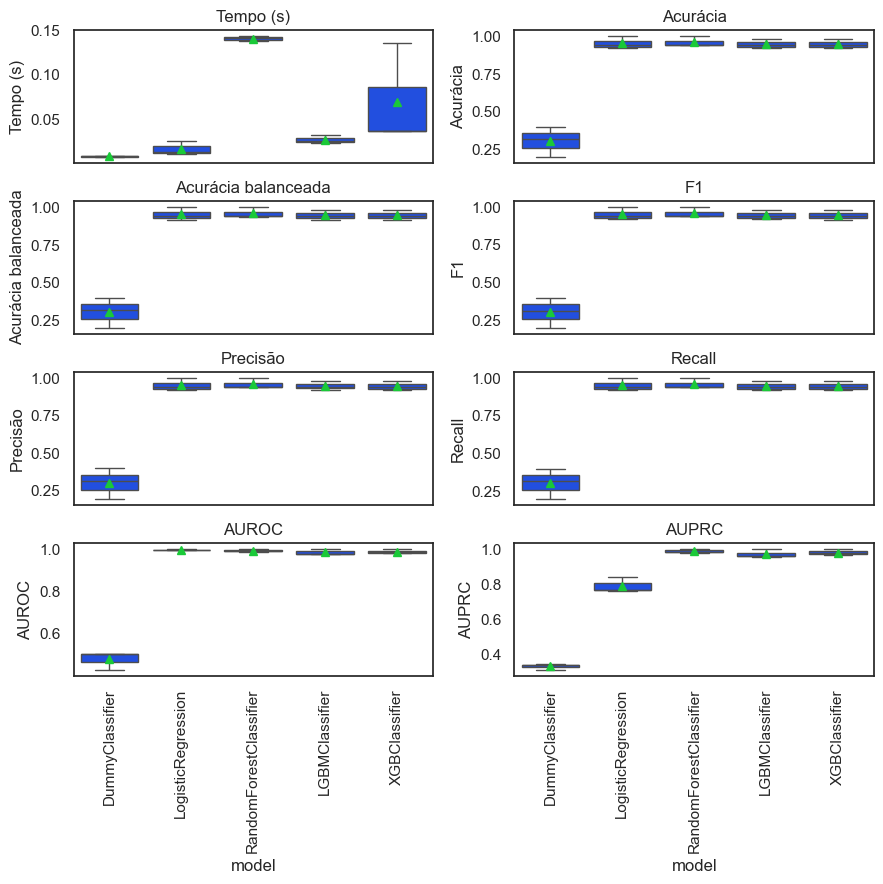

In [11]:
plot_comparar_metricas_modelos(df_resultados, multi_class=True)

O modelo de RandomForest destacou-se comparado aos demais classificadores, contudo, esse modelo é o mais lento no tempo de execução, tornando os outros modelos muito interessantes quando olhamos na perspectiva de aumento de performance em detrimento da diminuição das métricas. Nesse notebook vamos dar sequência nos estudos utilizando o classificador com melhores métricas que é o RandomForest, já que a base não é extensa e podemos treinar nosso modelo sem grandes dificuldades.

In [12]:
param_grid = {
    'clf__n_estimators': [10, 50, 100], # Número de árvores
    'clf__max_features': [None, 'sqrt', 'log2'], # Features para divisão
}

In [13]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, None, refit_metric='accuracy', multi_class=True
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_features': [None, 'sqrt', 'log2'],
                         'clf__n_estimators': [10, 50, 100]},
             refit='accuracy',
             scoring=['accuracy', 'balanced_accuracy', 'f1_weighted',
                      'precision_weighted', 'recall_weighted', 'roc_auc_ovr',
                      'average_precision'],
             verbose=1)

In [14]:
grid_search.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_features': [None, 'sqrt', 'log2'],
                         'clf__n_estimators': [10, 50, 100]},
             refit='accuracy',
             scoring=['accuracy', 'balanced_accuracy', 'f1_weighted',
                      'precision_weighted', 'recall_weighted', 'roc_auc_ovr',
                      'average_precision'],
             verbose=1)

In [15]:
grid_search.best_params_

{'clf__max_features': None, 'clf__n_estimators': 100}

In [16]:
grid_search.best_score_

np.float64(0.96)

In [17]:
grid_search.best_estimator_

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_features=None, random_state=42))])

In [18]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X) 

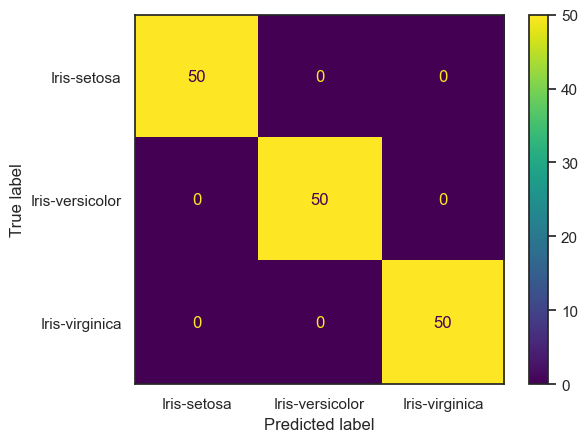

In [19]:
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

disp.plot()

In [20]:
print(classification_report(y, y_pred, target_names=le.classes_))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      1.00      1.00        50
 Iris-virginica       1.00      1.00      1.00        50

       accuracy                           1.00       150
      macro avg       1.00      1.00      1.00       150
   weighted avg       1.00      1.00      1.00       150



## Conclusão

O dataset de Iris é um clássico e bastante útil para aprendizado de modelos classificadores. É possível construir algoritmos pouco complexos e obter resultados satisfatórios, já que a base é bastante balanceada e classes linearmente separáveis.